In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('CompleteResponses.csv', sep=',')
test = pd.read_csv('SurveyIncomplete.csv', sep=',')

In [ ]:
df = pd.concat([data, test])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14898 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   salary   14898 non-null  float64
 1   age      14898 non-null  int64  
 2   elevel   14898 non-null  int64  
 3   car      14898 non-null  int64  
 4   zipcode  14898 non-null  int64  
 5   credit   14898 non-null  float64
 6   brand    14898 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 931.1 KB


In [ ]:
df.describe()

,salary,age,elevel,car,zipcode,credit,brand
count,14898.000000,14898.000000,14898.000000,14898.000000,14898.000000,14898.000000,14898.000000
mean,85180.618027,49.831387,1.991744,10.549671,4.039737,249300.227632,0.417304
std,37743.033955,17.619517,1.417721,5.782548,2.577085,145424.477651,0.493131
min,20000.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,52287.301907,35.000000,1.000000,6.000000,2.000000,121256.331925,0.000000
50%,85309.897320,50.000000,2.000000,11.000000,4.000000,250731.566450,0.000000
75%,117714.057875,65.000000,3.000000,16.000000,6.000000,375199.176175,1.000000
max,150000.000000,80.000000,4.000000,20.000000,8.000000,500000.000000,1.000000


In [ ]:
df.duplicated().sum()

0

In [ ]:
data_clustering = df.copy()

In [ ]:
data_clustering = df.drop('brand', axis=1)

In [ ]:
bins = [24, 49, 74, 99, 149]
labels = ['0-25', '25-50', '50-75', '75-100']
data_clustering['age_group'] = pd.cut(data_clustering['age'], bins=bins, labels=labels)

In [ ]:
data_clustering['credit_salary_ratio'] = data_clustering['credit'] / data_clustering['salary']

In [ ]:
car_counts = data_clustering['car'].value_counts()
data_clustering['car_freq'] = data_clustering['car'].map(car_counts)

In [ ]:
data_clustering = pd.get_dummies(data_clustering, columns=['zipcode', 'age_group', 'elevel'], drop_first=True)

In [ ]:
columns_to_drop = ['car', 'age']
data_final = data_clustering.drop(columns=columns_to_drop)

In [ ]:
features_to_scale = ['credit_salary_ratio', 'credit', 'salary']

scaler = StandardScaler()
data_final[features_to_scale] = scaler.fit_transform(data_final[features_to_scale])

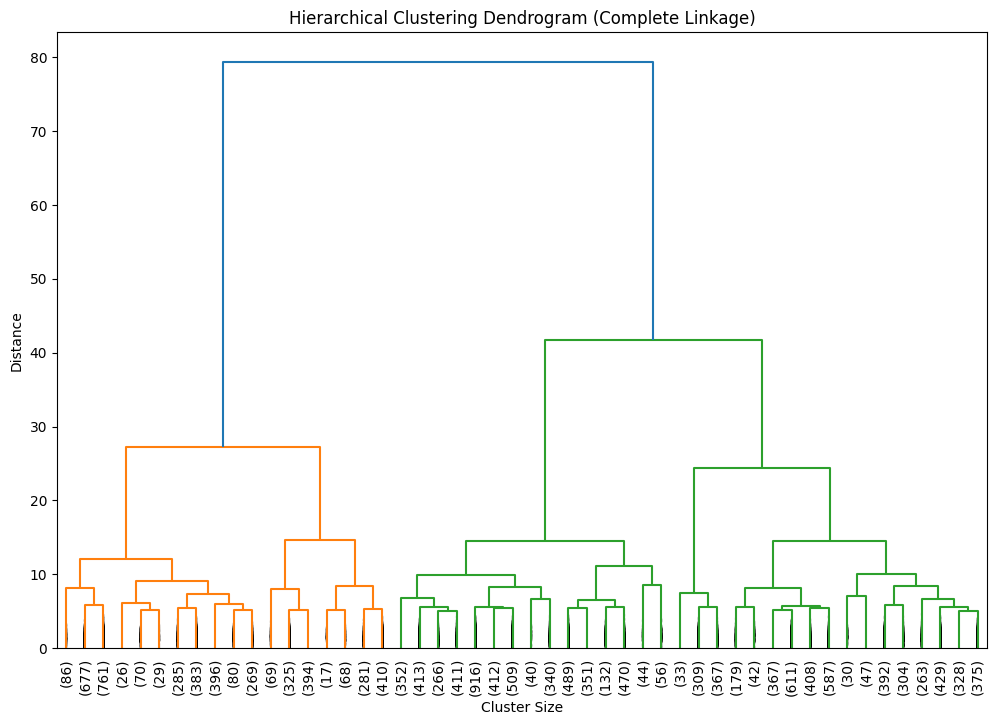

In [ ]:
Z = linkage(data_final, 'complete')

plt.figure(figsize=(12, 8))
dendrogram(Z,
           truncate_mode='lastp',
           p=50,
           leaf_rotation=90.,
           leaf_font_size=10.,
           show_contracted=True)

plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_final)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df.reset_index(drop=True, inplace=True)

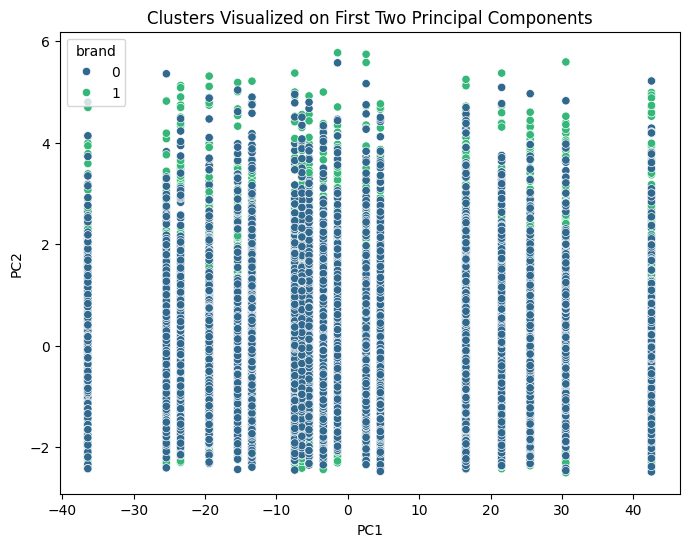

In [ ]:
pca_df['brand'] = df['brand'].values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='brand', data=pca_df, palette='viridis')
plt.title('Clusters Visualized on First Two Principal Components')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(data_final)

tsne_df = pd.DataFrame(data=tsne_results, columns=['Dim1', 'Dim2'])

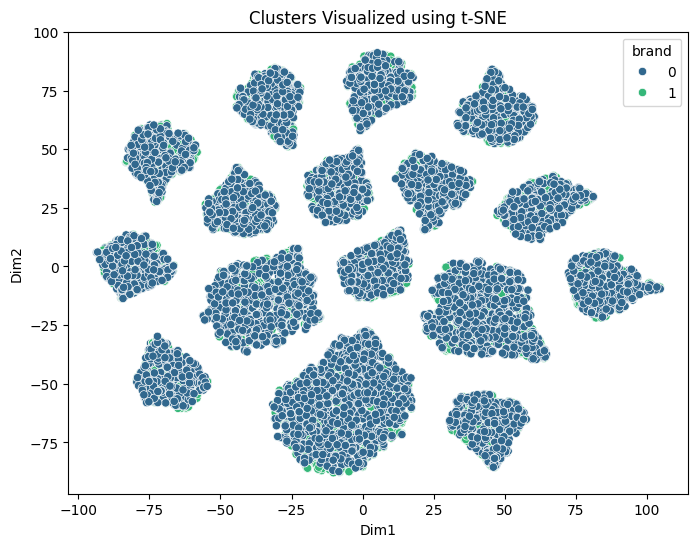

In [ ]:
tsne_df['brand'] = df['brand'].values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Dim1', y='Dim2', hue='brand', data=tsne_df, palette='viridis')
plt.title('Clusters Visualized using t-SNE')
plt.show()

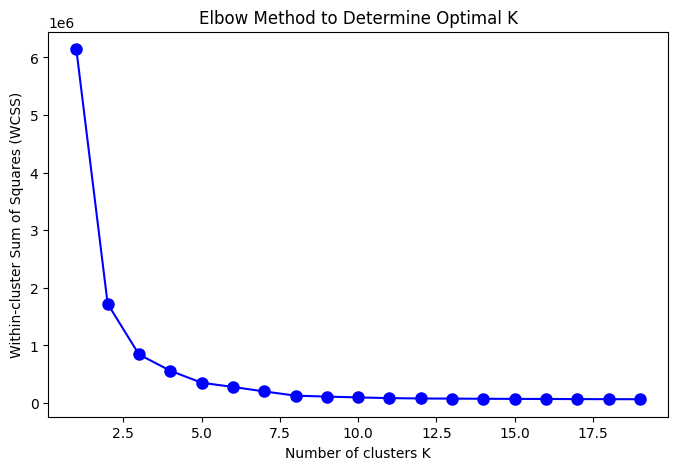

In [ ]:
wcss = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_final)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 20), wcss, 'bo-', markersize=8)
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of clusters K')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()

In [ ]:
optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data_final.drop('cluster', axis=1))

data_final['cluster'] = kmeans.labels_

In [ ]:
sil_score = silhouette_score(data_final.drop('cluster', axis=1), data_final['cluster'])
print(f'Silhouette Score for K={optimal_k}: {sil_score:.3f}')

Silhouette Score for K=2: 0.647


In [ ]:
ch_score = calinski_harabasz_score(data_final.drop('cluster', axis=1), data_final['cluster'])
print(f'Calinski-Harabasz Index for K={optimal_k}: {ch_score:.3f}')

Calinski-Harabasz Index for K=2: 38201.289


In [ ]:
db_score = davies_bouldin_score(data_final.drop('cluster', axis=1), data_final['cluster'])
print(f'Davies-Bouldin Index for K={optimal_k}: {db_score:.3f}')

Davies-Bouldin Index for K=2: 0.474


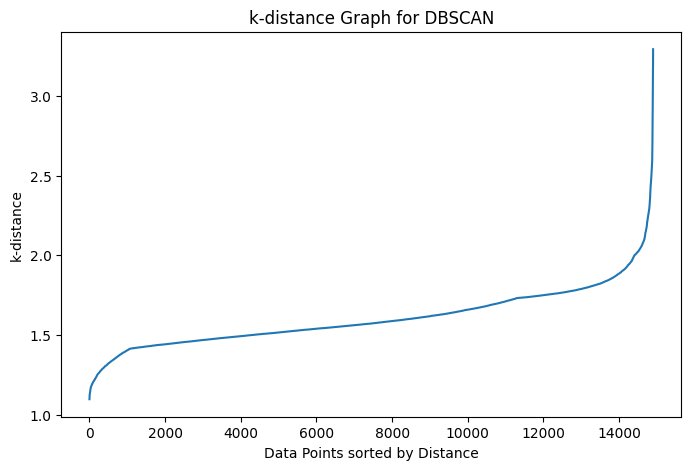

In [ ]:
from sklearn.neighbors import NearestNeighbors

min_samples = data_final.shape[1] + 1

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_final)
distances, indices = neighbors_fit.kneighbors(data_final)

distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('k-distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by Distance')
plt.ylabel('k-distance')
plt.show()

In [ ]:
dbscan = DBSCAN(eps=2, min_samples=min_samples)

dbscan.fit(data_final.drop('cluster', axis=1))
tsne_df['dbscan_cluster'] = dbscan.labels_

In [ ]:
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

if n_clusters_ > 1:
    sil_score_dbscan = silhouette_score(tsne_df.drop(['dbscan_cluster'], axis=1), labels)
    print(f'Silhouette Score for DBSCAN: {sil_score_dbscan:.3f}')
else:
    print('Silhouette Score cannot be computed with less than 2 clusters.')

Estimated number of clusters: 16
Estimated number of noise points: 57
Silhouette Score for DBSCAN: 0.565


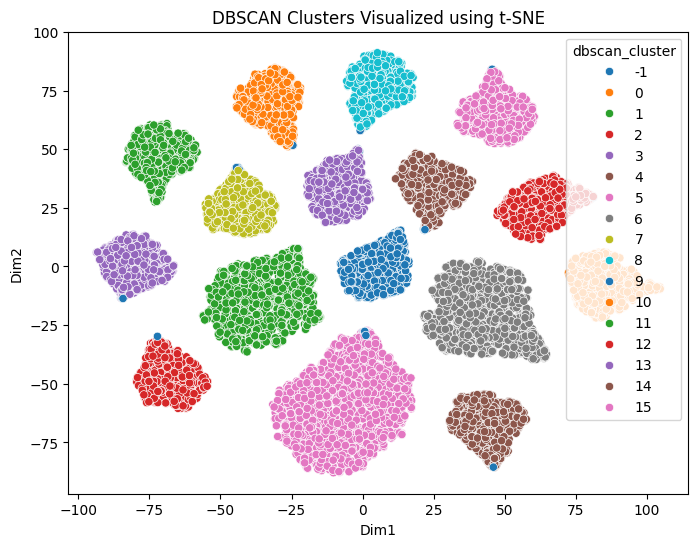

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Dim1', y='Dim2', hue='dbscan_cluster', data=tsne_df, palette='tab10')
plt.title('DBSCAN Clusters Visualized using t-SNE')
plt.show()

In [ ]:
data_clustered = data.copy()
data_final.reset_index(drop=True, inplace=True)
data_clustered['kmeans_cluster'] = data_final['cluster']

cluster_profile = data_clustered.groupby('kmeans_cluster').mean()
print("KMeans Cluster Profiles:")
cluster_profile

KMeans Cluster Profiles:


,salary,age,elevel,car,zipcode,credit,brand
kmeans_cluster,,,,,,,
0,84402.126499,50.348815,1.985710,13.673920,4.013641,249503.439010,0.621306
1,85082.511677,49.521191,1.981669,9.098695,4.053087,249028.102199,0.621939


In [ ]:
data_clustered = data.copy()
data_clustered['dbscan_cluster'] = tsne_df['dbscan_cluster']

cluster_profile = data_clustered.groupby('dbscan_cluster').mean()
print("DBSCAN Cluster Profiles:")
cluster_profile

DBSCAN Cluster Profiles:


,salary,age,elevel,car,zipcode,credit,brand
dbscan_cluster,,,,,,,
-1,21412.643167,53.305556,1.861111,10.722222,4.055556,455233.866231,0.916667
0,81596.952746,48.445122,2.079268,14.000000,4.323171,257729.818090,0.640244
1,85929.170977,49.882166,1.952229,13.489384,4.123142,251851.132657,0.613588
2,83777.127428,49.933457,1.990758,15.000000,3.961183,241716.667136,0.600739
3,86833.191161,49.489496,1.993697,6.000000,4.100840,246838.442822,0.644958
4,85056.755442,49.718200,2.021526,8.000000,3.915851,252181.559885,0.628180
5,86602.239293,50.147440,2.030034,11.657338,4.102389,243661.806625,0.606143
6,84982.687806,50.154985,1.998026,11.017769,4.150049,249767.159913,0.626851
7,85569.464905,48.555076,1.963283,13.000000,4.047516,241577.416325,0.613391
